### FROM SAV TO LOVE

# HW № 8 Image Generation

Реализовать синтезирование лиц из LFW с помощью DCGAN         
Библиотеки: [Python, Tensorflow]  

### Подключение библиотек и скриптов

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# For Google Colaboratory
%tensorflow_version 2.x

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### Загрузка данных

In [ ]:
tfds.disable_progress_bar()

(train_ds), ds_info = tfds.load('lfw', 
                                as_supervised=True, 
                                with_info=True, 
                                split='train'
                                )

### Изучение датасета

In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

In [ ]:
train_ds

<PrefetchDataset shapes: ((), (250, 250, 3)), types: (tf.string, tf.uint8)>

In [ ]:
len(train_ds)

13233

### Визуализация датасета - Labeled Faces in the Wild

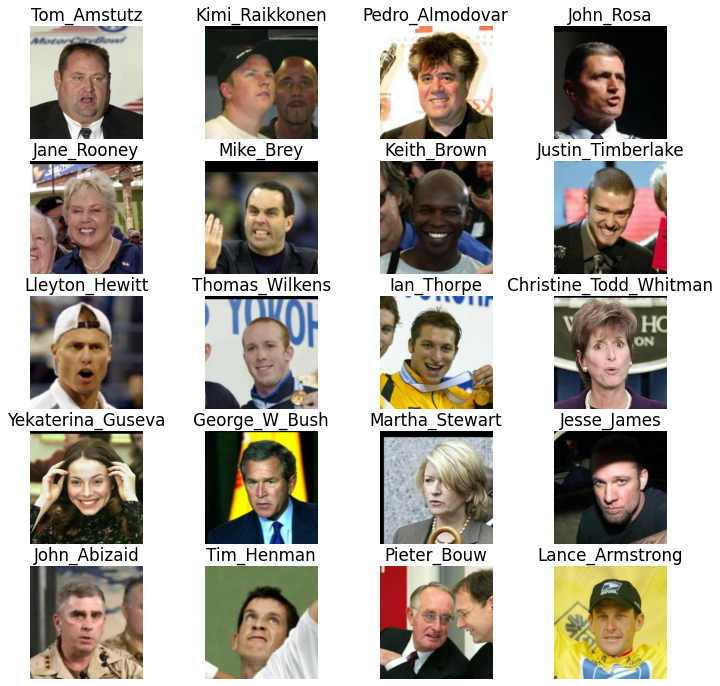

In [ ]:
plt.figure(figsize=(12, 12))
for i, x in enumerate(train_ds.take(20)):
    plt.subplot(5, 4, i+1)
    plt.title(x[0].numpy().decode('utf-8'))
    plt.imshow(x[1])
    plt.axis('off')

### Создание пайплайна данных

In [ ]:
INP_SIZE = 128
EPOCHS = 40
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2

def prepare_images(label, img):
    img = tf.cast(img, tf.float32) / 255
    img = tf.image.resize(img, (INP_SIZE, INP_SIZE))
    return img

train_ds = train_ds.shuffle(buffer_size=len(train_ds))
train_ds = train_ds.map(prepare_images)
train_ds = train_ds.repeat(EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

In [ ]:
train_ds

<BatchDataset shapes: (16, 128, 128, 3), types: tf.float32>

### Deep Convolutional GAN (DCGAN)

In [ ]:
momentum = 0.6

generator = tf.keras.Sequential([
    tf.keras.layers.Dense(256*32*32, activation='relu'),
    tf.keras.layers.Reshape((32, 32, 256)),
    tf.keras.layers.UpSampling2D((2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=momentum),
    tf.keras.layers.ReLU(),
    tf.keras.layers.UpSampling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=momentum),
    tf.keras.layers.ReLU(),
     
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'), 
    tf.keras.layers.BatchNormalization(momentum=momentum),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='tanh')
])

In [ ]:
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),  

    tf.keras.layers.Conv2D(64, kernel_size=5, strides=(2, 2), padding='same'),
    # tf.keras.layers.BatchNormalization(momentum=momentum),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, kernel_size=5, strides=(2, 2), padding='same'),
    # tf.keras.layers.BatchNormalization(momentum=momentum),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(256, kernel_size=5, strides=(1, 1), padding='same'),
    # tf.keras.layers.BatchNormalization(momentum=momentum),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

In [ ]:
LEARNING_RATE = 0.00019
INPUT_DIM = 100

optimizer = tf.keras.optimizers.RMSprop(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def dcgan_images(samples):
    fig = plt.figure(figsize=(12, 12))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        ax.imshow((samples[j] * 255).astype(np.uint8))
        plt.xticks([]), plt.yticks([])
    plt.show()

### Train model

In [ ]:
%%time

D_losses = []   
G_losses = []

for step, true_images in enumerate(train_ds):
    
    # Train Discriminator
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    D_losses.append(d_loss_value)
    G_losses.append(g_loss_value)

    # Check intermediate results
    if step % 1000 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        dcgan_images(syntetic_images)

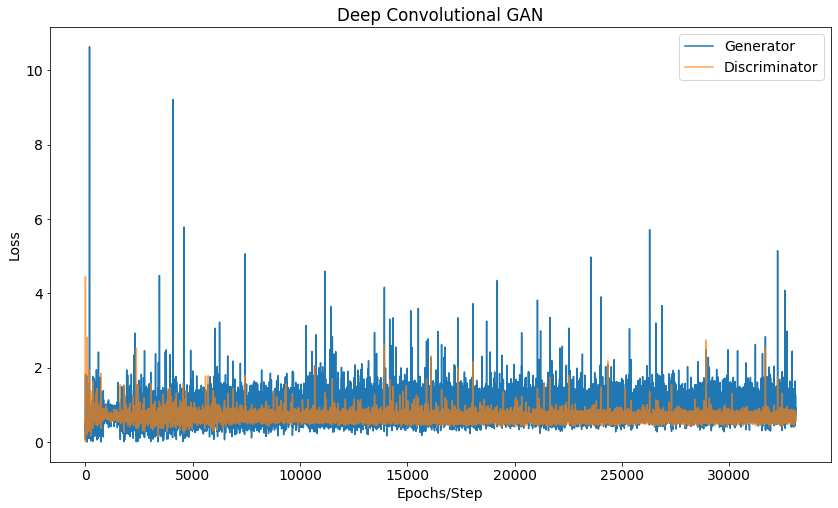

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(G_losses, label='Generator')
plt.plot(D_losses, label='Discriminator', alpha=0.7)
plt.legend()
plt.xlabel('Epochs/Step')
plt.ylabel('Loss')
plt.title('Deep Convolutional GAN')
plt.show()

### Тестирование свёрточного генератора

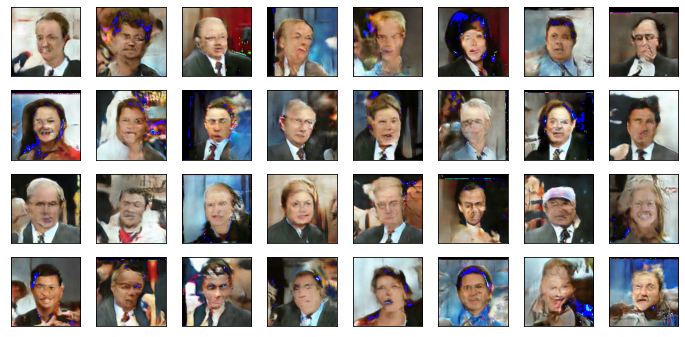

In [ ]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
dcgan_images(syntetic_images)

### Интерполяция в латентном пространстве

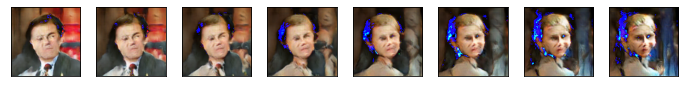

In [ ]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
dcgan_images(syntetic_images)